# Capsule Network Implementation

Author: Gyanendar Manohar

Date: 20/03/2022

Referance:

* Code adapted from https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulenet.py

* Author: Xifeng Guo, E-mail: guoxifeng1990@163.com, Github: https://github.com/XifengGuo/CapsNet-Keras

Details:

Architure similar to present in the original paper for MINST dataset

32 Primary Capusle, 16 dimension output vector


The decoder part is acts as regularizer which prevent overfitting during training of the newtork. 

There is no decoder part here which has been removed to make training faster.

Loss of capsule network is margin loss + alpha * reconsutruction loss
As decoder network is not present, only margin loss is considered

# Headers

In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split



print(tf.__version__)

Using TensorFlow backend.


2.7.0


# Set Seed

In [2]:
#Set Seed for random number generation
def set_seed(seed = 100):
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

# CapsNet

In [3]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    Vector length is treated as probability which should lies between 0 and 1. This
    function brings the vector length in the range of 0 and 1
    @param vectors: vectors to be squashed, N-dim tensor
    @param axis: the axis to squash
    @return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    @param num_capsule: number of capsules in this layer
    @param dim_capsule: dimension of the output vectors of the capsules in this layer
    @param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    @param inputs: 4D tensor, shape=[None, width, height, channels]
    @param dim_capsule: the dim of the output vector of capsule
    @param n_channels: the number of types of capsules
    @return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [4]:
K.set_image_data_format('channels_last')

In [5]:
class CapsuleNet:
  @staticmethod
  def build(input_shape,number_of_class,routing_count,batch_size,
            n_channels = 32,dim_capsule=16,
            kernels=[9],filters=[256],strides=[1],
            multi_level_feature_extraction = False):
    
   

   #@param input_shape: data shape, 3d, [width, height, channels]
   #@param number_of_class: number of classes
   #@param routing_count: number of routing iterations
   #@param batch_size: size of batch
   #@return: Two Keras Models, the first one used for training, and the second one for evaluation.
   #        `eval_model` can also be used for training.
   

   input = layers.Input(shape=input_shape, batch_size=batch_size)  

  
   #THis part if for experimentation
   if multi_level_feature_extraction == True:
      conv1_1 = layers.Conv2D(filters=128, 
                             kernel_size=9,                              
                             padding='valid', 
                             activation='relu')(input)
      
      conv2_1 = layers.Conv2D(filters=128, 
                             kernel_size=9,                              
                             padding='valid', 
                             activation='relu')(input)
      
      conv2_2 = layers.Conv2D(filters=128, 
                             kernel_size=5,                              
                             padding='valid', 
                             activation='relu')(conv1_1)
      print(f"conv2_2:{conv2_2.shape}")                             
                                                                   
      conv = layers.concatenate([conv1_1, conv2_1])
   else:
      # Basic core model
      for index in range(len(kernels)):
          if index == 0 :
            conv = layers.Conv2D(filters=filters[index], 
                                kernel_size=kernels[index], 
                                strides=strides[index], 
                                padding='valid', 
                                activation='relu', 
                                name='conv'+str(index))(input)
          else:
            conv = layers.Conv2D(filters=filters[index], 
                                kernel_size=kernels[index], 
                                strides=strides[index], 
                                padding='valid', 
                                activation='relu', 
                                name='conv'+str(index))(conv)
  
   
   conv_1 = layers.Conv2D(filters=dim_capsule*n_channels, 
                             kernel_size=kernels[-1], 
                             strides=strides[-1], 
                             padding='valid', 
                             activation='relu', 
                             name='primary_capsule_conv')(conv)

   
    
   conv_2 = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(conv_1)
   primary_capsule = layers.Lambda(squash,name = 'primary_capsule')(conv_2)
   digitcaps = CapsuleLayer(num_capsule=number_of_class, 
                             dim_capsule=dim_capsule, 
                             routings=routing_count, 
                             name='digitcaps')(primary_capsule)    
   out_caps = Length(name='capsnet')(digitcaps)
   train_model = models.Model(input,outputs=out_caps)
   return train_model

In [6]:
def margin_loss(y_true, y_pred):
    
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, 1))

# Train

In [7]:
# Train Capsule Network
@tf.autograph.experimental.do_not_convert
def train(model, data, args):
    """
    Training a CapsuleNet
    @param model: the CapsuleNet model
    @param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    @param args: arguments
    return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks to save the best model   
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights.h5', monitor='val_accuracy',
                                           save_best_only=True, save_weights_only=True, verbose=1)    
    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],run_eagerly=True,
                  metrics={'capsnet': 'accuracy'})

    # Train the model
    train_image_generator = ImageDataGenerator()  
    train_data_generator = train_image_generator.flow(x_train, y_train, batch_size=args.batch_size)
    val_image_generator = ImageDataGenerator()
    val_data_generator = val_image_generator.flow(x_test,y_test,batch_size = args.batch_size)
   
    history = model.fit(train_data_generator,
              steps_per_epoch=int(y_train.shape[0] / args.batch_size),
              epochs=args.epochs,              
              validation_data=val_data_generator, batch_size=args.batch_size,
              callbacks=[checkpoint])
 
    index = history.history["val_accuracy"].index(max(history.history["val_accuracy"]))
    best_val_accuracy = history.history["val_accuracy"][index]    
    print(f"Best Validation Accuracy:{best_val_accuracy}") 
    plot_model_performance(history)
   
    return model

# Plot Model Performance

In [8]:
from matplotlib import pyplot as plt
def plot_model_performance(history):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

# Train and Test The Model

In [9]:
@tf.autograph.experimental.do_not_convert
def get_model_train_test(data,args,n_channels = 32,
                                      dim_capsule=16,
                                      kernels=[9],
                                      filters=[256],
                                      strides=[1],
                                      multi_level_feature_extraction = False):
  set_seed()
  (x_train,y_train),(x_test,y_test) = data
  # Build the model
  model = CapsuleNet.build(input_shape=x_train.shape[1:], 
                                      number_of_class=len(np.unique(np.argmax(y_train, 1))),
                                      routing_count=args.routings,
                                      batch_size=args.batch_size,
                                      n_channels=n_channels,
                                      dim_capsule = dim_capsule,
                                      kernels = kernels,
                                      filters= filters,
                                      strides = strides,
                                      multi_level_feature_extraction=multi_level_feature_extraction)

  model.summary()
  # Train the model
  trained_model = train(model=model, data=((x_train, y_train), (x_test, y_test)), args=args)
  #Load the weight where accuracy was maximum
  trained_model.load_weights(f'./result/weights.h5')
  # Model Training Done
  #Prediction and calculate the matrix value
 
  y_pred= trained_model.predict(x_test,batch_size=x_test.shape[0])
  
  print("*******Model Performance*************")
  print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])  

 
  result_pred = np.argmax(y_pred, axis=1) 
  result_actual = np.argmax(y_test, axis=1) 
  precision = precision_score(result_actual, result_pred)
  recall = recall_score(result_actual, result_pred)
  f1 = f1_score(result_actual, result_pred)
  tn, fp, fn, tp = confusion_matrix(result_actual, result_pred).ravel()
  fpr, tpr, thresholds = metrics.roc_curve(result_actual, result_pred)
  auc = metrics.auc(fpr, tpr)
  
  print(f"Precision:{precision}")
  print(f"recall:{recall}")
  print(f"f1:{f1}")
  print(f"AUC:{auc}")
  print(f"Sensitivity:{tp/(tp+fn)}")
  print(f"specificity:{tn/(tn+fp)}")

# Arguments

In [10]:
import argparse
import os
def get_arguments():
    parser = argparse.ArgumentParser(description="Capsule Network Glaucoma Classification.")
    parser.add_argument('--epochs', default=15, type=int)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--lr', default=0.0001, type=float,
                            help="Initial learning rate")
    parser.add_argument('--lr_decay', default=1, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
    parser.add_argument('--lam_recon', default=0.392, type=float,
                        help="The coefficient for the loss of decoder")
    parser.add_argument('-r', '--routings', default=1, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")
    parser.add_argument('--shift_fraction', default=0.1, type=float,
                        help="Fraction of pixels to shift at most in each direction.")
    parser.add_argument('--debug', action='store_true',
                        help="Save weights by TensorBoard")
    parser.add_argument('--save_dir', default='./result')
    parser.add_argument('--augmentation', default=False, type=bool)
    parser.add_argument('-t', '--testing', action='store_true',
                        help="Test the trained model on testing dataset")
    parser.add_argument('--digit', default=5, type=int,
                        help="Digit to manipulate")
    parser.add_argument('-w', '--weights', default=None,
                        help="The path of the saved weights. Should be specified when testing")
    args, unknown = parser.parse_known_args()
    print(args)

    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    
    return args

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load DataSet

In [11]:
#RIM_ONE_DL_DIR = '/content/gdrive/My Drive/dataset/rim_one_dl/partitioned_randomly'
RIM_ONE_DL_DIR = 'C:\gyani\Projects_MS\code\dataset\RIM-ONE_DL_images\partitioned_randomly'
ACRIMA_DIR = 'C:\gyani\Projects_MS\code\dataset\ACRIMA_dataset\Database'
RIM_ONE_R2_DIR = 'C:\gyani\Projects_MS\code\dataset\RIMONE-db-r2'

Image Size

In [12]:
HEIGHT= 32
WIDTH = 32

Preprocess Image: Generate Array

In [13]:
# Resize image to HEIGHT*WIDTH
# Convert to numpy array
def process_image(data_set_dir, label_dict, width,height,histogram_eq = False):
    
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                #gray_image = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2GRAY)
                if histogram_eq == True:
                  full_size_image_YUW = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2YUV)
                  full_size_image_YUW[:,:,0] = cv2.equalizeHist(full_size_image_YUW[:,:,0])
                  full_size_image = cv2.cvtColor(full_size_image_YUW, cv2.COLOR_YUV2BGR)
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label

# RIMONE DL

In [14]:
def get_rim_one_dl(histogram_eq = False):
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_DL_DIR+"/training_set",
                                                  class_labels,
                                                  WIDTH,HEIGHT,
                                                  histogram_eq = histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  test_images,test_labels = process_image(RIM_ONE_DL_DIR+"/test_set",
                                          class_labels,
                                          WIDTH,HEIGHT,
                                          histogram_eq = histogram_eq)
  
  test_label = (pd.Series(test_labels).map(class_labels)).values
  test_label = to_categorical(test_label.astype('float32'))
  test_images = test_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  return (training_images,training_label),(test_images,test_label)

# RIMEONE V2

In [15]:
def get_rim_one_db_r2(test_train_ratio = 0.2,histogram_eq = False):
  
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  WIDTH,HEIGHT,
                                                  histogram_eq = histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

# ACRIMA

In [16]:
def get_acrima_dataset(test_train_ratio = 0.2,histogram_eq = False):
  class_labels = {}
  training_images,training_labels = process_image(ACRIMA_DIR,
                                                  class_labels,
                                                  WIDTH,HEIGHT,
                                                  histogram_eq = histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

# RIMONE DL

In [51]:
args = get_arguments()
args.batch_size = 32
args.epochs = 50
args.routings = 8
data = get_rim_one_dl()

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(32, 32, 32, 3)]         0         
_________________________________________________________________
conv0 (Conv2D)               (32, 24, 24, 256)         62464     
_________________________________________________________________
primary_capsule_conv (Conv2D (32, 16, 16, 512)         10617344  
_________________________________________________________________
primarycap_reshape (Reshape) (32, 8192, 16)            0         
_________________________________________________________________
primary_capsule (Lambda)     (32, 8192, 16)            0         
_________________________________________________________________
digitcaps (CapsuleLayer)     (32, 2, 16)               4194304   
_________________________________________________________________
capsnet (Length)             (32, 2)                   0   

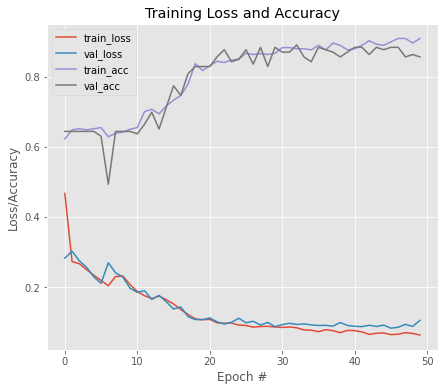

*******Model Performance*************
Test acc: 0.8904109589041096
Precision:0.875
recall:0.9680851063829787
f1:0.9191919191919191
AUC:0.8590425531914894
Sensitivity:0.9680851063829787
specificity:0.75


In [56]:
get_model_train_test(data,args)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(32, 32, 32, 3)]         0         
_________________________________________________________________
conv0 (Conv2D)               (32, 24, 24, 256)         62464     
_________________________________________________________________
primary_capsule_conv (Conv2D (32, 16, 16, 512)         10617344  
_________________________________________________________________
primarycap_reshape (Reshape) (32, 8192, 16)            0         
_________________________________________________________________
primary_capsule (Lambda)     (32, 8192, 16)            0         
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


10/10 [==============================] - 3s 253ms/step - loss: 0.4671 - accuracy: 0.6221 - val_loss: 0.2820 - val_accuracy: 0.6438

Epoch 00001: val_accuracy improved from -inf to 0.64384, saving model to ./result\weights.h5
Epoch 2/50
10/10 [==============================] - 2s 249ms/step - loss: 0.2727 - accuracy: 0.6482 - val_loss: 0.3049 - val_accuracy: 0.6438

Epoch 00002: val_accuracy did not improve from 0.64384
Epoch 3/50
10/10 [==============================] - 2s 250ms/step - loss: 0.2674 - accuracy: 0.6515 - val_loss: 0.2763 - val_accuracy: 0.6438

Epoch 00003: val_accuracy did not improve from 0.64384
Epoch 4/50
10/10 [==============================] - 2s 252ms/step - loss: 0.2498 - accuracy: 0.6482 - val_loss: 0.2535 - val_accuracy: 0.6438

Epoch 00004: val_accuracy did not improve from 0.64384
Epoch 5/50
10/10 [==============================] - 2s 250ms/step - loss: 0.2267 - accuracy: 0.6482 - val_loss: 0.2287 - val_accuracy: 0.6438

Epoch 00005: val_accuracy did not impr

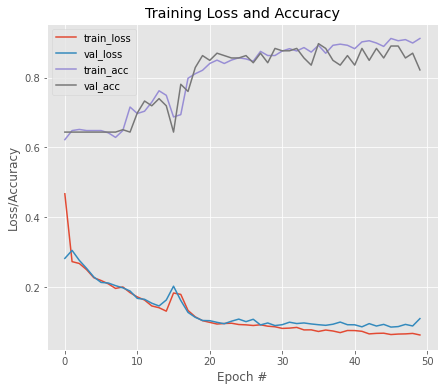

*******Model Performance*************
Test acc: 0.8972602739726028
Precision:0.883495145631068
recall:0.9680851063829787
f1:0.9238578680203046
AUC:0.8686579378068738
Sensitivity:0.9680851063829787
specificity:0.7692307692307693


In [57]:
args = get_arguments()
args.batch_size = 32
args.epochs = 50
args.routings = 3
data = get_rim_one_dl()
get_model_train_test(data,args)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(32, 32, 32, 3)]         0         
_________________________________________________________________
conv0 (Conv2D)               (32, 24, 24, 256)         62464     
_________________________________________________________________
primary_capsule_conv (Conv2D (32, 16, 16, 512)         10617344  
_________________________________________________________________
primarycap_reshape (Reshape) (32, 8192, 16)            0         
_________________________________________________________________
primary_capsule (Lambda)     (32, 8192, 16)            0         
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


10/10 [==============================] - 9s 904ms/step - loss: 0.4671 - accuracy: 0.6221 - val_loss: 0.2818 - val_accuracy: 0.6438

Epoch 00001: val_accuracy improved from -inf to 0.64384, saving model to ./result\weights.h5
Epoch 2/50
10/10 [==============================] - 9s 906ms/step - loss: 0.2727 - accuracy: 0.6482 - val_loss: 0.3052 - val_accuracy: 0.6438

Epoch 00002: val_accuracy did not improve from 0.64384
Epoch 3/50
10/10 [==============================] - 9s 908ms/step - loss: 0.2674 - accuracy: 0.6515 - val_loss: 0.2764 - val_accuracy: 0.6438

Epoch 00003: val_accuracy did not improve from 0.64384
Epoch 4/50
10/10 [==============================] - 9s 906ms/step - loss: 0.2496 - accuracy: 0.6482 - val_loss: 0.2524 - val_accuracy: 0.6438

Epoch 00004: val_accuracy did not improve from 0.64384
Epoch 5/50
10/10 [==============================] - 9s 908ms/step - loss: 0.2251 - accuracy: 0.6417 - val_loss: 0.2293 - val_accuracy: 0.6438

Epoch 00005: val_accuracy did not impr

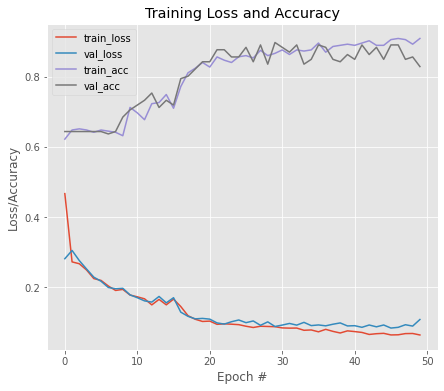

*******Model Performance*************
Test acc: 0.8972602739726028
Precision:0.883495145631068
recall:0.9680851063829787
f1:0.9238578680203046
AUC:0.8686579378068738
Sensitivity:0.9680851063829787
specificity:0.7692307692307693


In [58]:
args = get_arguments()
args.batch_size = 32
args.epochs = 50
args.routings = 1
data = get_rim_one_dl()
get_model_train_test(data,args)

In [19]:
HEIGHT= 32
WIDTH = 32

# RIMONE V2

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 32, 32, 3)]         0         
_________________________________________________________________
conv0 (Conv2D)               (32, 24, 24, 256)         62464     
_________________________________________________________________
primary_capsule_conv (Conv2D (32, 16, 16, 512)         10617344  
_________________________________________________________________
primarycap_reshape (Reshape) (32, 8192, 16)            0         
_________________________________________________________________
primary_capsule (Lambda)     (32, 8192, 16)            0         
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


11/11 [==============================] - 3s 270ms/step - loss: 0.4819 - accuracy: 0.5663 - val_loss: 0.3866 - val_accuracy: 0.5604

Epoch 00001: val_accuracy improved from -inf to 0.56044, saving model to ./result\weights.h5
Epoch 2/100
11/11 [==============================] - 3s 269ms/step - loss: 0.3623 - accuracy: 0.5783 - val_loss: 0.2604 - val_accuracy: 0.5604

Epoch 00002: val_accuracy did not improve from 0.56044
Epoch 3/100
11/11 [==============================] - 3s 268ms/step - loss: 0.3402 - accuracy: 0.4910 - val_loss: 0.3422 - val_accuracy: 0.5604

Epoch 00003: val_accuracy did not improve from 0.56044
Epoch 4/100
11/11 [==============================] - 3s 271ms/step - loss: 0.2821 - accuracy: 0.5663 - val_loss: 0.2417 - val_accuracy: 0.5604

Epoch 00004: val_accuracy did not improve from 0.56044
Epoch 5/100
11/11 [==============================] - 3s 284ms/step - loss: 0.2368 - accuracy: 0.5241 - val_loss: 0.2240 - val_accuracy: 0.5604

Epoch 00005: val_accuracy did not 

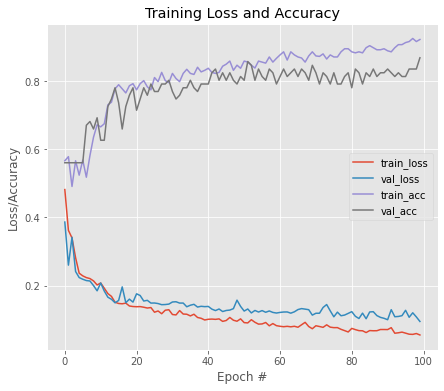

*******Model Performance*************
Test acc: 0.8681318681318682
Precision:0.8305084745762712
recall:0.9607843137254902
f1:0.890909090909091
AUC:0.8553921568627452
Sensitivity:0.9607843137254902
specificity:0.75


In [21]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 8
data = get_rim_one_db_r2()
get_model_train_test(data,args)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 32, 32, 3)]         0         
_________________________________________________________________
conv0 (Conv2D)               (32, 24, 24, 256)         62464     
_________________________________________________________________
primary_capsule_conv (Conv2D (32, 16, 16, 512)         10617344  
_________________________________________________________________
primarycap_reshape (Reshape) (32, 8192, 16)            0         
_________________________________________________________________
primary_capsule (Lambda)     (32, 8192, 16)            0         
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


11/11 [==============================] - 10s 935ms/step - loss: 0.4818 - accuracy: 0.5663 - val_loss: 0.3866 - val_accuracy: 0.5604

Epoch 00001: val_accuracy improved from -inf to 0.56044, saving model to ./result\weights.h5
Epoch 2/100
11/11 [==============================] - 10s 929ms/step - loss: 0.3621 - accuracy: 0.5783 - val_loss: 0.2551 - val_accuracy: 0.5604

Epoch 00002: val_accuracy did not improve from 0.56044
Epoch 3/100
11/11 [==============================] - 10s 929ms/step - loss: 0.3389 - accuracy: 0.4759 - val_loss: 0.3467 - val_accuracy: 0.5604

Epoch 00003: val_accuracy did not improve from 0.56044
Epoch 4/100
11/11 [==============================] - 10s 929ms/step - loss: 0.2842 - accuracy: 0.5663 - val_loss: 0.2357 - val_accuracy: 0.5604

Epoch 00004: val_accuracy did not improve from 0.56044
Epoch 5/100
11/11 [==============================] - 10s 932ms/step - loss: 0.2359 - accuracy: 0.5181 - val_loss: 0.2201 - val_accuracy: 0.5604

Epoch 00005: val_accuracy did

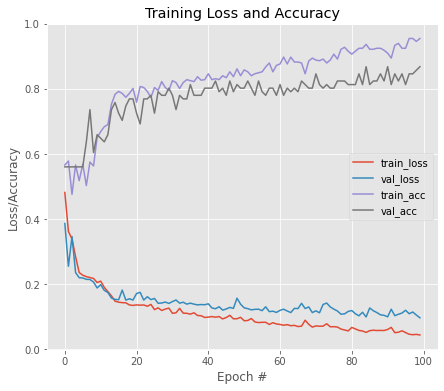

*******Model Performance*************
Test acc: 0.8681318681318682
Precision:0.8305084745762712
recall:0.9607843137254902
f1:0.890909090909091
AUC:0.8553921568627452
Sensitivity:0.9607843137254902
specificity:0.75


In [22]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 3
data = get_rim_one_db_r2()
get_model_train_test(data,args)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(32, 32, 32, 3)]         0         
_________________________________________________________________
conv0 (Conv2D)               (32, 24, 24, 256)         62464     
_________________________________________________________________
primary_capsule_conv (Conv2D (32, 16, 16, 512)         10617344  
_________________________________________________________________
primarycap_reshape (Reshape) (32, 8192, 16)            0         
_________________________________________________________________
primary_capsule (Lambda)     (32, 8192, 16)            0         
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


11/11 [==============================] - 11s 950ms/step - loss: 0.4818 - accuracy: 0.5663 - val_loss: 0.3866 - val_accuracy: 0.5604

Epoch 00001: val_accuracy improved from -inf to 0.56044, saving model to ./result\weights.h5
Epoch 2/100
11/11 [==============================] - 10s 947ms/step - loss: 0.3621 - accuracy: 0.5783 - val_loss: 0.2536 - val_accuracy: 0.5604

Epoch 00002: val_accuracy did not improve from 0.56044
Epoch 3/100
11/11 [==============================] - 10s 946ms/step - loss: 0.3363 - accuracy: 0.4789 - val_loss: 0.3425 - val_accuracy: 0.5604

Epoch 00003: val_accuracy did not improve from 0.56044
Epoch 4/100
11/11 [==============================] - 10s 944ms/step - loss: 0.2796 - accuracy: 0.5663 - val_loss: 0.2356 - val_accuracy: 0.5604

Epoch 00004: val_accuracy did not improve from 0.56044
Epoch 5/100
11/11 [==============================] - 10s 947ms/step - loss: 0.2338 - accuracy: 0.5211 - val_loss: 0.2221 - val_accuracy: 0.5604

Epoch 00005: val_accuracy did

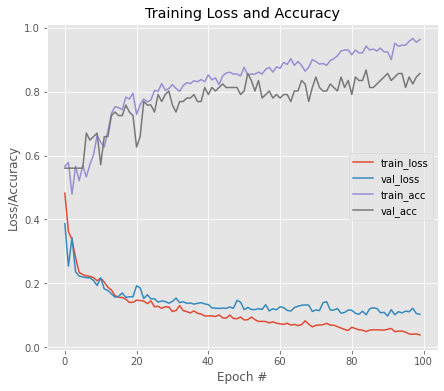

*******Model Performance*************
Test acc: 0.8681318681318682
Precision:0.8305084745762712
recall:0.9607843137254902
f1:0.890909090909091
AUC:0.8553921568627452
Sensitivity:0.9607843137254902
specificity:0.75


In [23]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
data = get_rim_one_db_r2()
get_model_train_test(data,args)

# ACRIMA

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(32, 32, 32, 3)]         0         
_________________________________________________________________
conv0 (Conv2D)               (32, 24, 24, 256)         62464     
_________________________________________________________________
primary_capsule_conv (Conv2D (32, 16, 16, 512)         10617344  
_________________________________________________________________
primarycap_reshape (Reshape) (32, 8192, 16)            0         
_________________________________________________________________
primary_capsule (Lambda)     (32, 8192, 16)            0         
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


17/17 [==============================] - 23s 1s/step - loss: 0.4114 - accuracy: 0.5526 - val_loss: 0.3634 - val_accuracy: 0.5887

Epoch 00001: val_accuracy improved from -inf to 0.58865, saving model to ./result\weights.h5
Epoch 2/100
17/17 [==============================] - 20s 1s/step - loss: 0.3329 - accuracy: 0.5545 - val_loss: 0.2853 - val_accuracy: 0.4113

Epoch 00002: val_accuracy did not improve from 0.58865
Epoch 3/100
17/17 [==============================] - 21s 1s/step - loss: 0.2272 - accuracy: 0.6176 - val_loss: 0.2097 - val_accuracy: 0.6312

Epoch 00003: val_accuracy improved from 0.58865 to 0.63121, saving model to ./result\weights.h5
Epoch 4/100
17/17 [==============================] - 20s 1s/step - loss: 0.2000 - accuracy: 0.6560 - val_loss: 0.1639 - val_accuracy: 0.7376

Epoch 00004: val_accuracy improved from 0.63121 to 0.73759, saving model to ./result\weights.h5
Epoch 5/100
17/17 [==============================] - 20s 1s/step - loss: 0.1756 - accuracy: 0.7180 - val

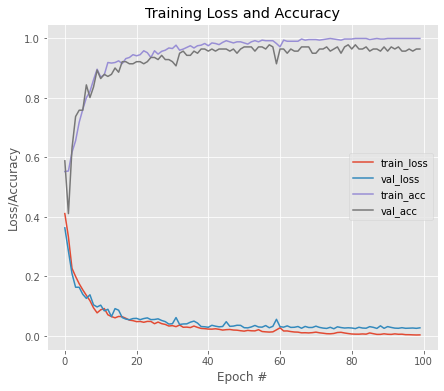

*******Model Performance*************
Test acc: 0.9787234042553191
Precision:0.9824561403508771
recall:0.9655172413793104
f1:0.9739130434782608
AUC:0.976734524304113
Sensitivity:0.9655172413793104
specificity:0.9879518072289156


In [25]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 8
data = get_acrima_dataset()
get_model_train_test(data,args)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(32, 32, 32, 3)]         0         
_________________________________________________________________
conv0 (Conv2D)               (32, 24, 24, 256)         62464     
_________________________________________________________________
primary_capsule_conv (Conv2D (32, 16, 16, 512)         10617344  
_________________________________________________________________
primarycap_reshape (Reshape) (32, 8192, 16)            0         
_________________________________________________________________
primary_capsule (Lambda)     (32, 8192, 16)            0         
_________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


17/17 [==============================] - 19s 1s/step - loss: 0.4116 - accuracy: 0.5526 - val_loss: 0.3660 - val_accuracy: 0.5887

Epoch 00001: val_accuracy improved from -inf to 0.58865, saving model to ./result\weights.h5
Epoch 2/100
17/17 [==============================] - 18s 1s/step - loss: 0.3338 - accuracy: 0.5564 - val_loss: 0.3501 - val_accuracy: 0.4113

Epoch 00002: val_accuracy did not improve from 0.58865
Epoch 3/100
17/17 [==============================] - 19s 1s/step - loss: 0.2350 - accuracy: 0.5901 - val_loss: 0.2227 - val_accuracy: 0.5957

Epoch 00003: val_accuracy improved from 0.58865 to 0.59574, saving model to ./result\weights.h5
Epoch 4/100
17/17 [==============================] - 19s 1s/step - loss: 0.2025 - accuracy: 0.6598 - val_loss: 0.1773 - val_accuracy: 0.7234

Epoch 00004: val_accuracy improved from 0.59574 to 0.72340, saving model to ./result\weights.h5
Epoch 5/100
17/17 [==============================] - 18s 1s/step - loss: 0.1759 - accuracy: 0.7124 - val

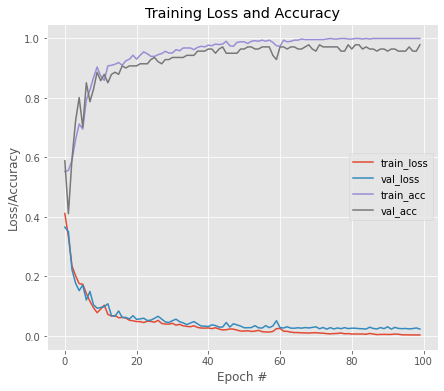

*******Model Performance*************
Test acc: 0.9787234042553191
Precision:1.0
recall:0.9482758620689655
f1:0.9734513274336283
AUC:0.9741379310344828
Sensitivity:0.9482758620689655
specificity:1.0


In [26]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 3
data = get_acrima_dataset()
get_model_train_test(data,args)

Namespace(augmentation=False, batch_size=32, debug=False, digit=5, epochs=15, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=1, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 32, 32, 3)]         0         
_________________________________________________________________
conv0 (Conv2D)               (32, 24, 24, 256)         62464     
_________________________________________________________________
primary_capsule_conv (Conv2D (32, 16, 16, 512)         10617344  
_________________________________________________________________
primarycap_reshape (Reshape) (32, 8192, 16)            0         
_________________________________________________________________
primary_capsule (Lambda)     (32, 8192, 16)            0         
___________________________________________________________

C:\Users\gyani-desktop\.conda\envs\lab3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:367: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


17/17 [==============================] - 8s 256ms/step - loss: 0.4117 - accuracy: 0.5526 - val_loss: 0.3666 - val_accuracy: 0.5887

Epoch 00001: val_accuracy improved from -inf to 0.58865, saving model to ./result\weights.h5
Epoch 2/100
17/17 [==============================] - 3s 170ms/step - loss: 0.3334 - accuracy: 0.5564 - val_loss: 0.3254 - val_accuracy: 0.4113

Epoch 00002: val_accuracy did not improve from 0.58865
Epoch 3/100
17/17 [==============================] - 3s 173ms/step - loss: 0.2311 - accuracy: 0.5956 - val_loss: 0.2153 - val_accuracy: 0.6454

Epoch 00003: val_accuracy improved from 0.58865 to 0.64539, saving model to ./result\weights.h5
Epoch 4/100
17/17 [==============================] - 3s 171ms/step - loss: 0.1975 - accuracy: 0.6635 - val_loss: 0.1826 - val_accuracy: 0.7021

Epoch 00004: val_accuracy improved from 0.64539 to 0.70213, saving model to ./result\weights.h5
Epoch 5/100
17/17 [==============================] - 3s 171ms/step - loss: 0.1758 - accuracy: 0.

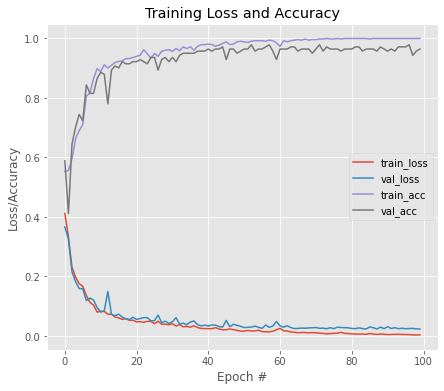

*******Model Performance*************
Test acc: 0.9787234042553191
Precision:0.9508196721311475
recall:1.0
f1:0.9747899159663865
AUC:0.9819277108433735
Sensitivity:1.0
specificity:0.963855421686747


In [17]:
args = get_arguments()
args.batch_size = 32
args.epochs = 100
args.routings = 1
data = get_acrima_dataset()
get_model_train_test(data,args)